In [1]:
import torch
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use gpu to run

In [3]:
class MatrixXRayProjector:
    def __init__(self, volume_shape, image_shape, pixel_spacing, SOD, SID):
        """
        Matrix-based implementation of the projection operator Π_k(X) = P·vec(X)
        
        Args:
            volume_shape: (m,n,p) or (n,n,n) - 3D volume dimensions
            image_shape: (h,w) - 2D detector dimensions
            pixel_spacing: (dx,dy) - Pixel spacing in mm 
            SOD: Source-to-Isocenter Distance in mm 
            SID: Source-to-Detector Distance in mm 
        """
        self.volume_shape = volume_shape
        self.image_shape = image_shape
        self.pixel_spacing = torch.tensor(pixel_spacing, device=device)
        self.SOD = SOD
        self.SID = SID
        
        # Precompute all possible voxel coordinates
        z, y, x = torch.meshgrid(
            torch.arange(volume_shape[0], device=device),
            torch.arange(volume_shape[1], device=device),
            torch.arange(volume_shape[2], device=device),
            indexing='ij'
        )
        self.voxel_coords = torch.stack((x, y, z), dim=-1).float() - torch.tensor(volume_shape, device=device)//2
        
    def get_rotation_matrix(self, alpha, beta):
        """Same rotation matrix as before"""
        cos_a, sin_a = math.cos(alpha), math.sin(alpha)
        cos_b, sin_b = math.cos(beta), math.sin(beta)
    
        return torch.tensor([
            [cos_b,         sin_b*sin_a,      sin_b*cos_a],
            [0,             cos_a,            -sin_a],
            [-sin_b,        cos_b*sin_a,      cos_b*cos_a]
        ], device=device)
    
    def build_projection_matrix(self, alpha, beta):
        """
        Build the sparse projection matrix P for given angles
        
        Returns:
            P: Sparse matrix of shape (h*w, m*n*p) where P[i*w+j, :] corresponds to pixel (i,j)
        """
        h, w = self.image_shape
        m, n, p = self.volume_shape
        total_pixels = h * w
        total_voxels = m * n * p
        
        # Initialize lists for sparse matrix construction
        row_indices = []
        col_indices = []
        
        # Apply rotation to all voxels
        R = self.get_rotation_matrix(alpha, beta)
        rotated_coords = torch.matmul(self.voxel_coords, R.T)
        
        # Perspective projection
        proj_coords = rotated_coords.clone()
        proj_coords[..., 2] += self.SOD
        
        # Only consider points in front of the detector
        valid_mask = proj_coords[..., 2] > 0
        valid_voxels = torch.nonzero(valid_mask)
        
        # Project valid voxels
        det_coords = (proj_coords[valid_mask][..., :2] / 
                     proj_coords[valid_mask][..., 2].unsqueeze(-1)) * self.SID
        
        # Convert to pixel coordinates
        pixel_coords = det_coords / self.pixel_spacing + torch.tensor([w/2, h/2], device=device)
        pixel_coords = pixel_coords.round().long()
        
        # Filter valid pixels
        pixel_valid = (
            (pixel_coords[:, 0] >= 0) & 
            (pixel_coords[:, 0] < w) & 
            (pixel_coords[:, 1] >= 0) & 
            (pixel_coords[:, 1] < h))
        
        valid_pixel_coords = pixel_coords[pixel_valid]
        valid_voxel_indices = valid_voxels[pixel_valid]
        
        # Convert voxel indices to linear indices
        voxel_linear_indices = (
            valid_voxel_indices[:, 0] * n * p + 
            valid_voxel_indices[:, 1] * p + 
            valid_voxel_indices[:, 2])
        
        # Convert pixel coordinates to linear indices
        pixel_linear_indices = (
            valid_pixel_coords[:, 1] * w + 
            valid_pixel_coords[:, 0])
        
        # Create sparse matrix
        indices = torch.stack([pixel_linear_indices, voxel_linear_indices], dim=0)
        values = torch.ones(len(pixel_linear_indices), device=device)
        
        P = torch.sparse_coo_tensor(
            indices, 
            values, 
            size=(total_pixels, total_voxels),
            device=device
        )
        
        return P
    
    def project_volume(self, X, alpha, beta):
        """
        Project using sparse matrix multiplication: Π_k(X) = P·vec(X)
        
        Args:
            X: Binary 3D volume tensor (m,n,p)
            alpha: Primary angle in radians
            beta: Secondary angle in radians
            
        Returns:
            Projected 2D binary image I_k (h,w)
        """
        # Build or get cached projection matrix
        P = self.build_projection_matrix(alpha, beta)
        
        # Vectorize input
        vec_X = X.flatten().float()
        
        # Sparse matrix multiplication
        proj_vec = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
        
        # Reshape and binarize
        proj_image = (proj_vec > 0).reshape(self.image_shape)
        
        return proj_image

In [4]:
def create_test_objects(volume_shape):
    """Create all 7 test 3D objects with consistent orientation"""
    volume = torch.zeros(volume_shape, device=device)
    center = torch.tensor(volume_shape) // 2
    
    # Create coordinate grids (Z,Y,X order for volume dimensions)
    z, y, x = torch.meshgrid(
        torch.arange(volume_shape[0], device=device),  # Z (depth)
        torch.arange(volume_shape[1], device=device),  # Y (vertical)
        torch.arange(volume_shape[2], device=device),  # X (horizontal)
        indexing='ij'
    )

    # 1. Cube (aligned with axes)
    cube_size = 20
    half = cube_size // 2
    cube = volume.clone()
    cube[center[0]-half:center[0]+half,
         center[1]-half:center[1]+half,
         center[2]-half:center[2]+half] = 1

    # 2. Cylinder (horizontal along X-axis)
    cylinder = volume.clone()
    radius = 10
    length = 30  # Length along X-axis
    mask = ((y - center[1])**2 + (z - center[0])**2 <= radius**2) & \
           (x >= center[2]-length//2) & (x <= center[2]+length//2)
    cylinder[mask] = 1

    # 3. Star (3D cross aligned with axes)
    star = volume.clone()
    cross_width = 5
    cross_length = 25
    # X-axis cross (horizontal)
    star[center[0]-cross_width//2:center[0]+cross_width//2,
         center[1]-cross_width//2:center[1]+cross_width//2,
         center[2]-cross_length//2:center[2]+cross_length//2] = 1
    # Y-axis cross (vertical)
    star[center[0]-cross_width//2:center[0]+cross_width//2,
         center[1]-cross_length//2:center[1]+cross_length//2,
         center[2]-cross_width//2:center[2]+cross_width//2] = 1
    # Z-axis cross (depth)
    star[center[0]-cross_length//2:center[0]+cross_length//2,
         center[1]-cross_width//2:center[1]+cross_width//2,
         center[2]-cross_width//2:center[2]+cross_width//2] = 1

    # 4. Sphere (perfectly symmetrical)
    sphere = volume.clone()
    sphere_radius = 15
    mask = ((x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2) <= sphere_radius**2
    sphere[mask] = 1

    # 5. Torus (donut, horizontal orientation)
    torus = volume.clone()
    R = 15  # Major radius
    r = 5   # Minor radius
    mask = (torch.sqrt((y - center[1])**2 + (z - center[0])**2) - R)**2 + (x - center[2])**2 <= r**2
    torus[mask] = 1

    # 6. Pyramid (base on XY plane, peak along +Z)
    pyramid = volume.clone()
    base_size = 25
    height = 25
    for level in range(height):
        current_size = base_size * (1 - level/height)
        if current_size < 1:
            break
        half = int(current_size // 2)
        pyramid[center[0] + level,
                center[1]-half:center[1]+half,
                center[2]-half:center[2]+half] = 1

    # 7. Helix (horizontal along X-axis)
    helix = volume.clone()
    helix_radius = 10
    turns = 2
    pitch = 30  # Height per full turn
    for t in torch.linspace(0, turns*2*np.pi, 100):
        x_pos = int(center[2] + helix_radius * math.cos(t))  # X-coordinate
        y_pos = int(center[1] + helix_radius * math.sin(t))  # Y-coordinate
        z_pos = int(center[0] + pitch * t / (2*np.pi))      # Z-coordinate
        if all(0 <= p < s for p, s in zip((z_pos, y_pos, x_pos), volume_shape)):
            helix[z_pos, y_pos, x_pos] = 1
        # Add thickness
        for dz, dy, dx in [(0,0,0), (0,0,1), (0,1,0), (1,0,0)]:
            nz, ny, nx = z_pos+dz, y_pos+dy, x_pos+dx
            if all(0 <= p < s for p, s in zip((nz, ny, nx), volume_shape)):
                helix[nz, ny, nx] = 1

    return {
        'Cube': cube,
        'Cylinder': cylinder,
        'Star': star,
        'Sphere': sphere,
        'Torus': torus,
        'Pyramid': pyramid,
        'Helix': helix
    }


Visualizing Cube...


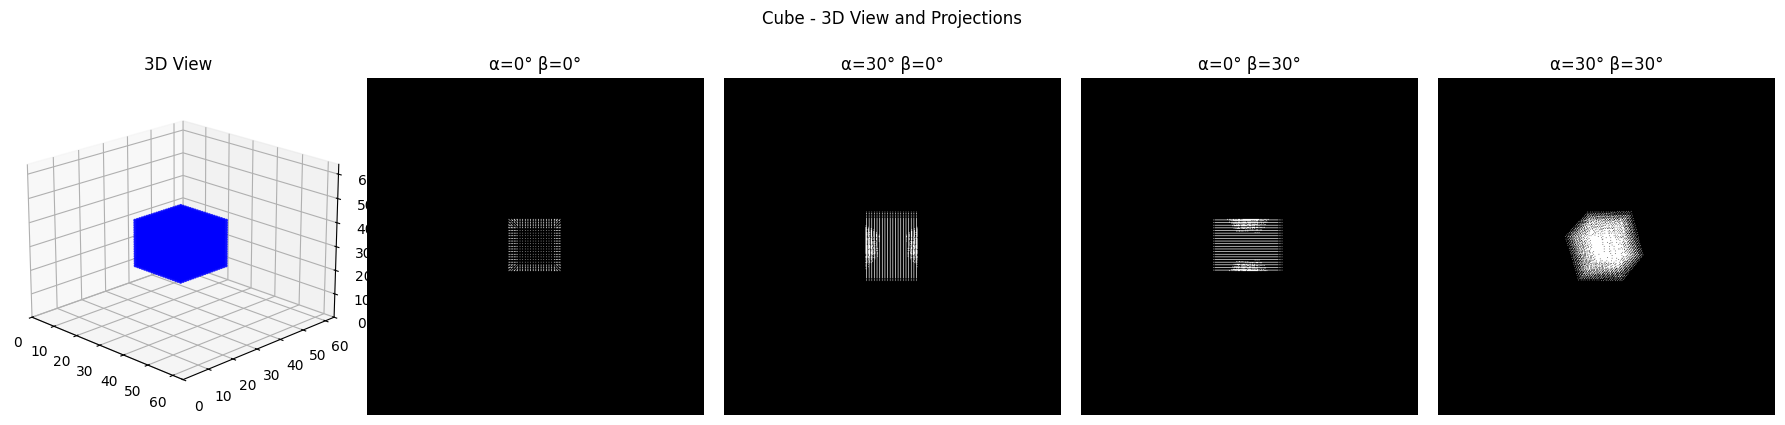


Visualizing Cylinder...


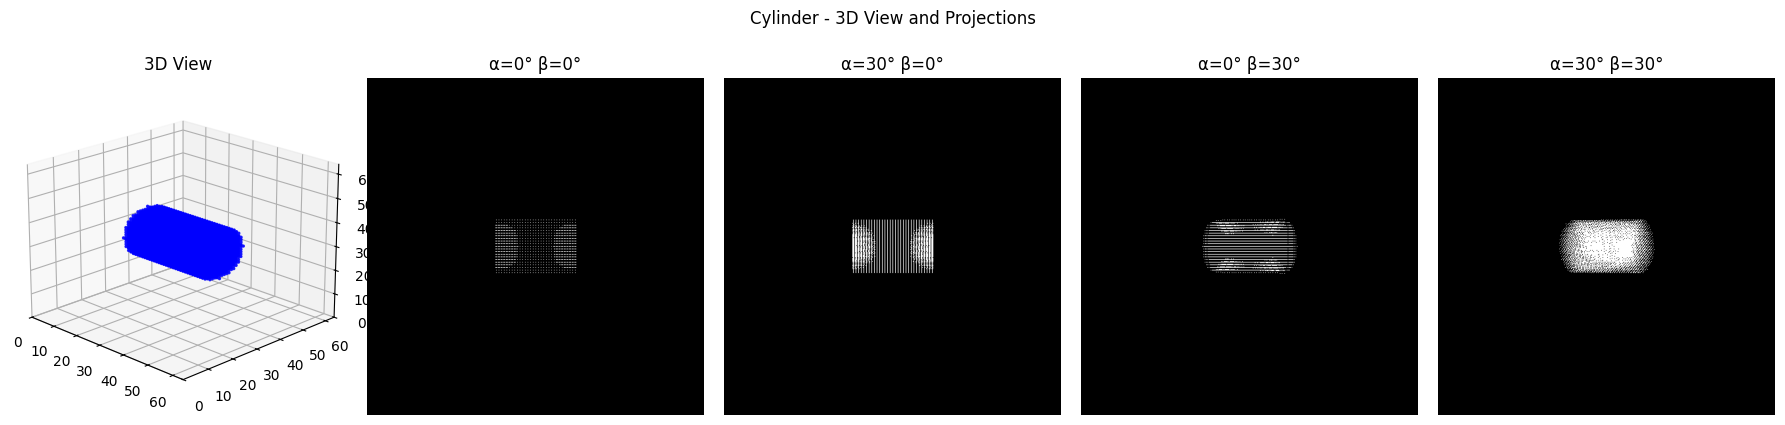


Visualizing Star...


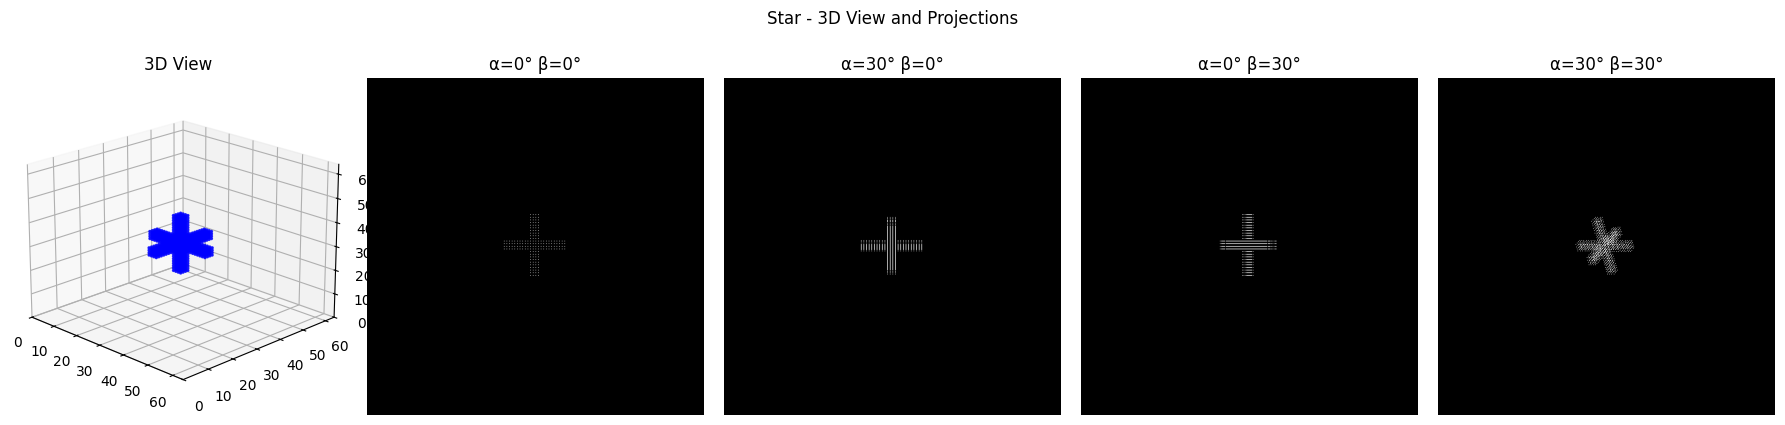


Visualizing Sphere...


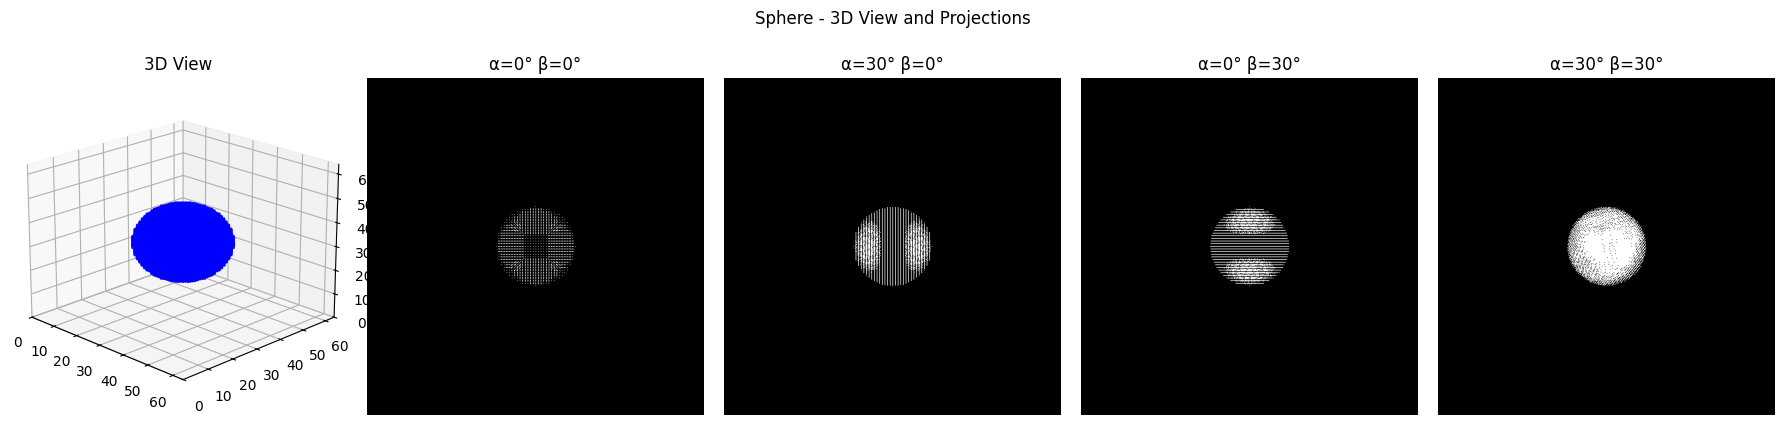


Visualizing Torus...


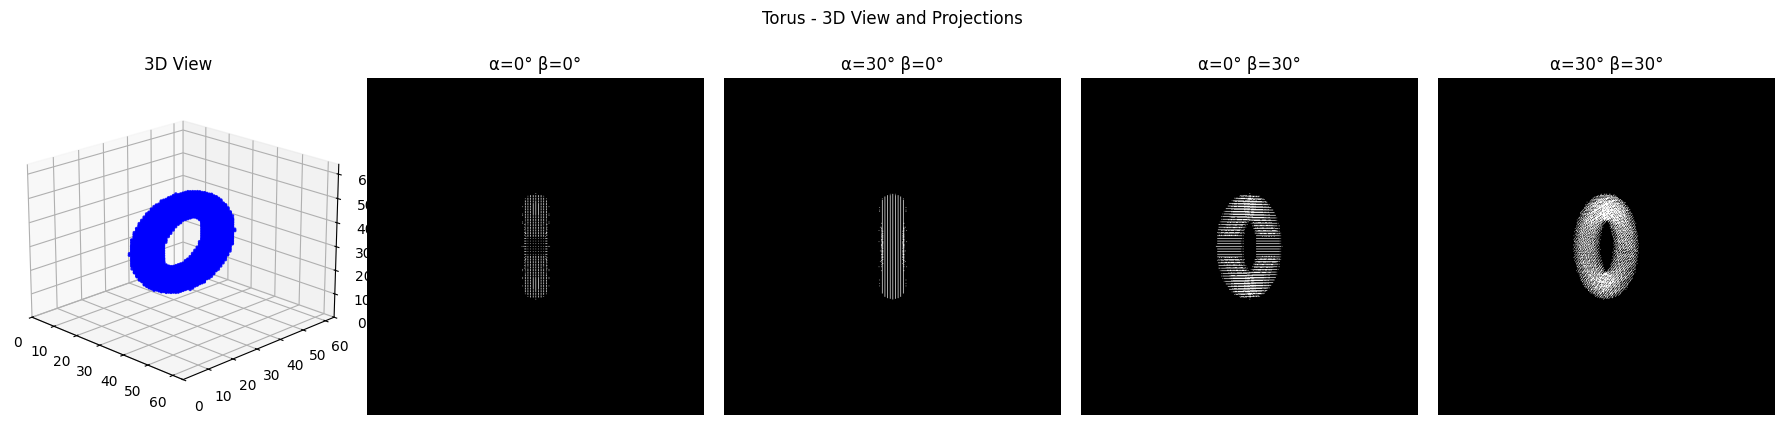


Visualizing Pyramid...


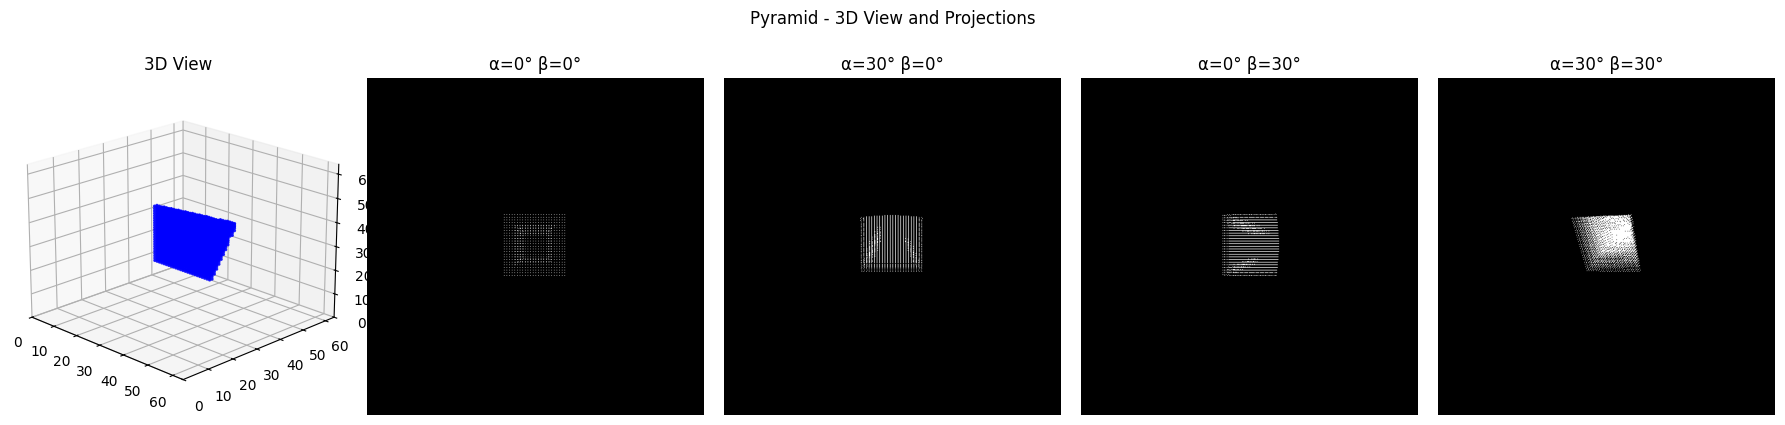


Visualizing Helix...


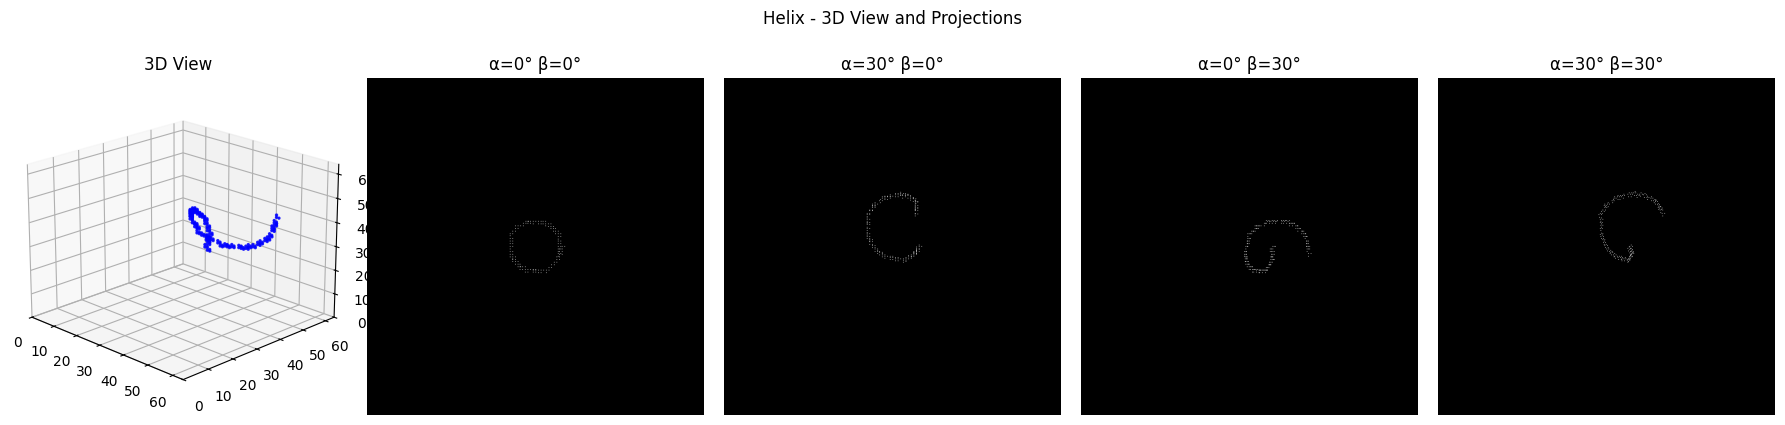

In [5]:
def plot_3d_voxels(voxels, title):
    """Visualize 3D voxels with consistent coordinate system"""
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    coords = torch.nonzero(voxels).cpu().numpy()
    if len(coords) > 0:
        # Plot as (X, Z, Y) to match projection views
        ax.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                  color='blue', s=2, alpha=0.8, depthshade=True)
    
    ax.set_xlabel('X (Horizontal)')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('Y (Vertical)')
    ax.set_title(title, pad=10)
    ax.set_xlim(0, voxels.shape[2])
    ax.set_ylim(0, voxels.shape[0])
    ax.set_zlim(0, voxels.shape[1])
    ax.view_init(elev=20, azim=-45)  # Standard isometric view
    plt.tight_layout()
    plt.show()

def visualize_all_objects(test_objects, projector):
    """Visualize 3D objects and their X-ray projections"""
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, obj_volume in test_objects.items():
        print(f"\nVisualizing {obj_name}...")
        
        # Combined visualization
        fig = plt.figure(figsize=(18, 4))
        fig.suptitle(f'{obj_name} - 3D View and Projections', y=1.05)
        
        # 3D View (subplot 1)
        ax_3d = fig.add_subplot(1, 5, 1, projection='3d')
        coords = torch.nonzero(obj_volume).cpu().numpy()
        if len(coords) > 0:
            ax_3d.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                         color='blue', s=2, alpha=0.8)
        ax_3d.set_title('3D View')
        ax_3d.set_xlim(0, obj_volume.shape[2])
        ax_3d.set_ylim(0, obj_volume.shape[0])
        ax_3d.set_zlim(0, obj_volume.shape[1])
        ax_3d.view_init(elev=20, azim=-45)
        
        # Projections (subplots 2-5)
        for i, (alpha, beta) in enumerate(angles):
            ax = fig.add_subplot(1, 5, i+2)
            proj_image = projector.project_volume(obj_volume, alpha, beta)
            ax.imshow(proj_image.cpu().numpy(), cmap='gray')
            ax.set_title(f'α={math.degrees(alpha):.0f}° β={math.degrees(beta):.0f}°')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

# Initialize and run visualization
volume_shape = (64, 64, 64)
projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
test_objects = create_test_objects(volume_shape)
visualize_all_objects(test_objects, projector)


Visualizing Cube...


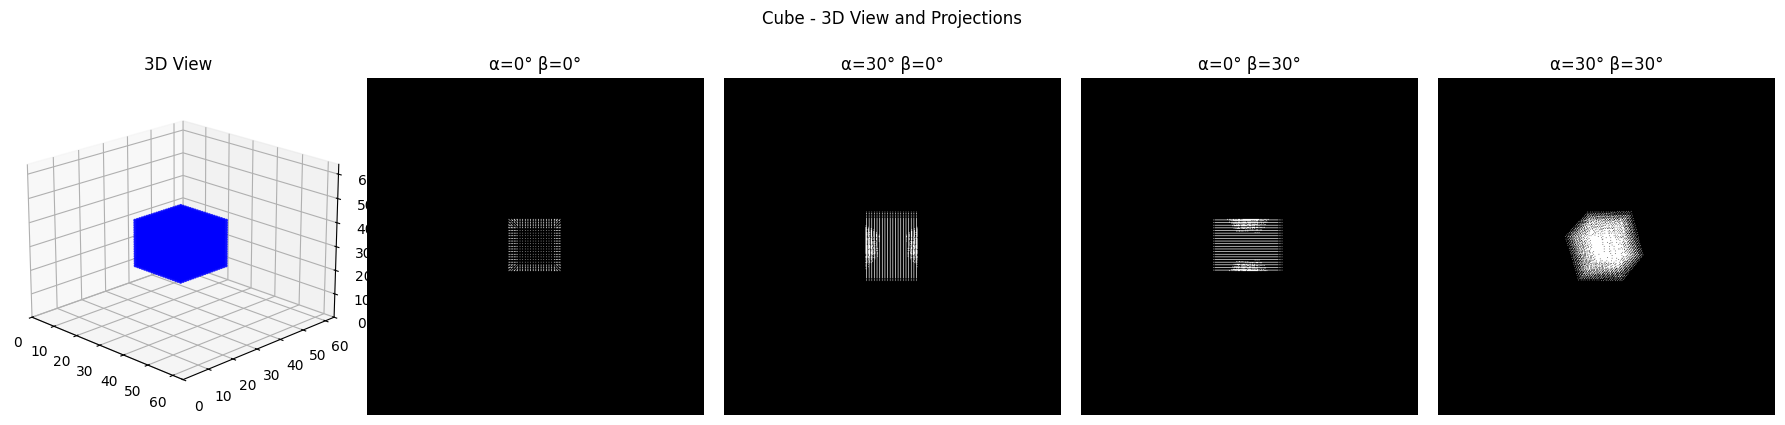


Visualizing Cylinder...


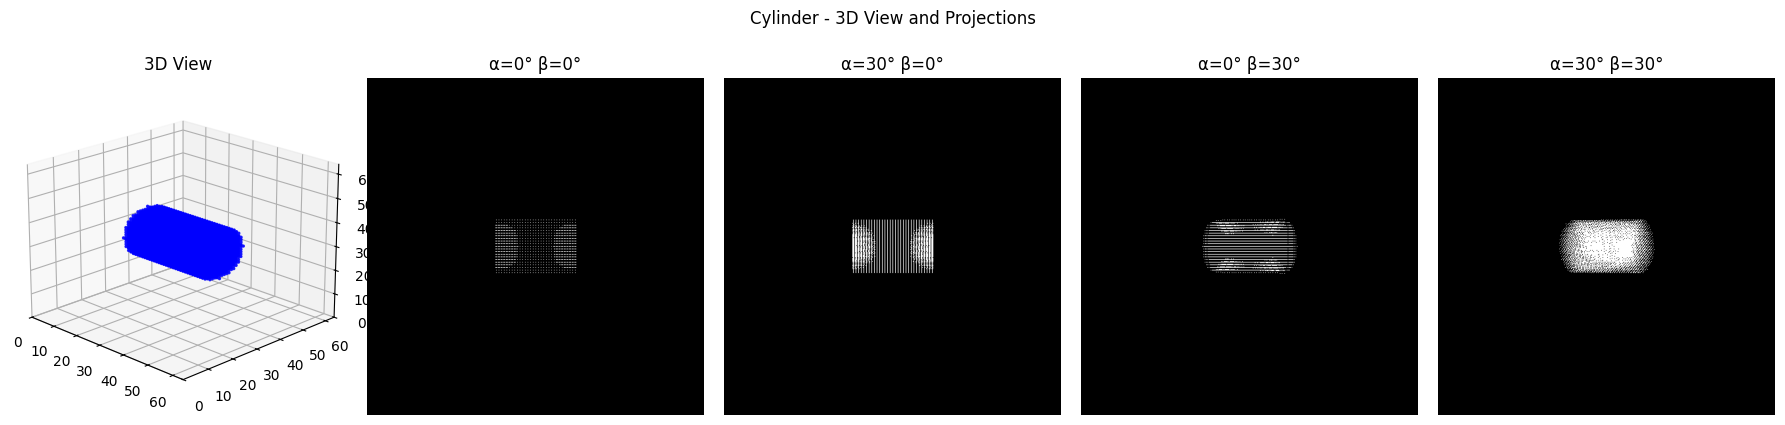


Visualizing Star...


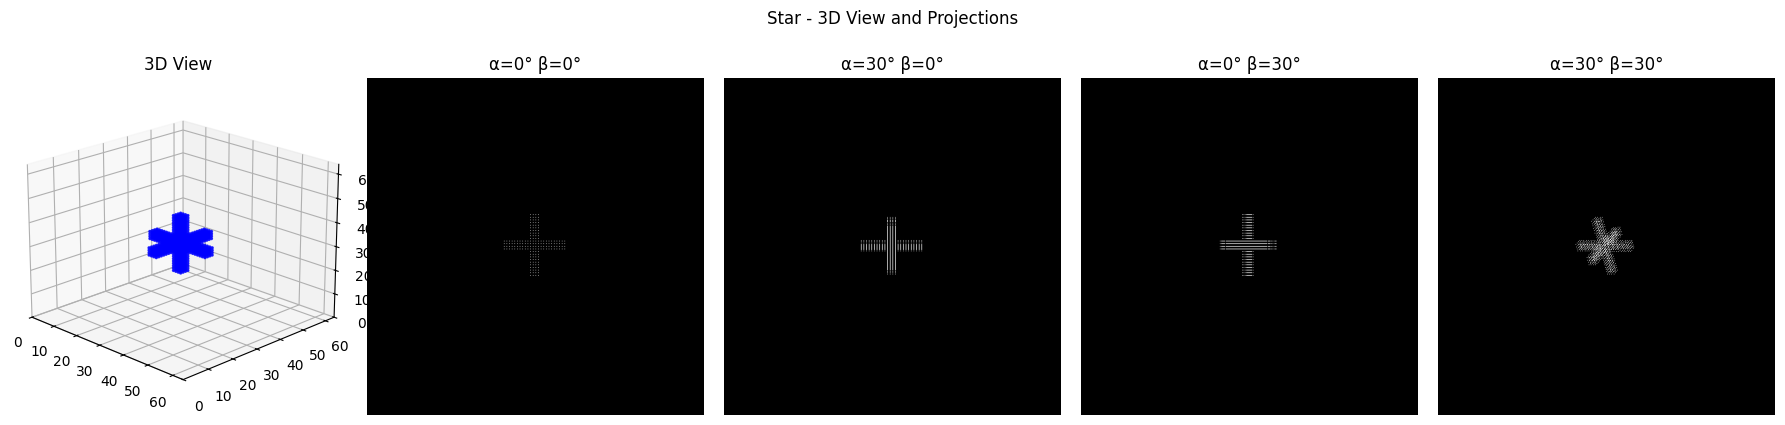


Visualizing Sphere...


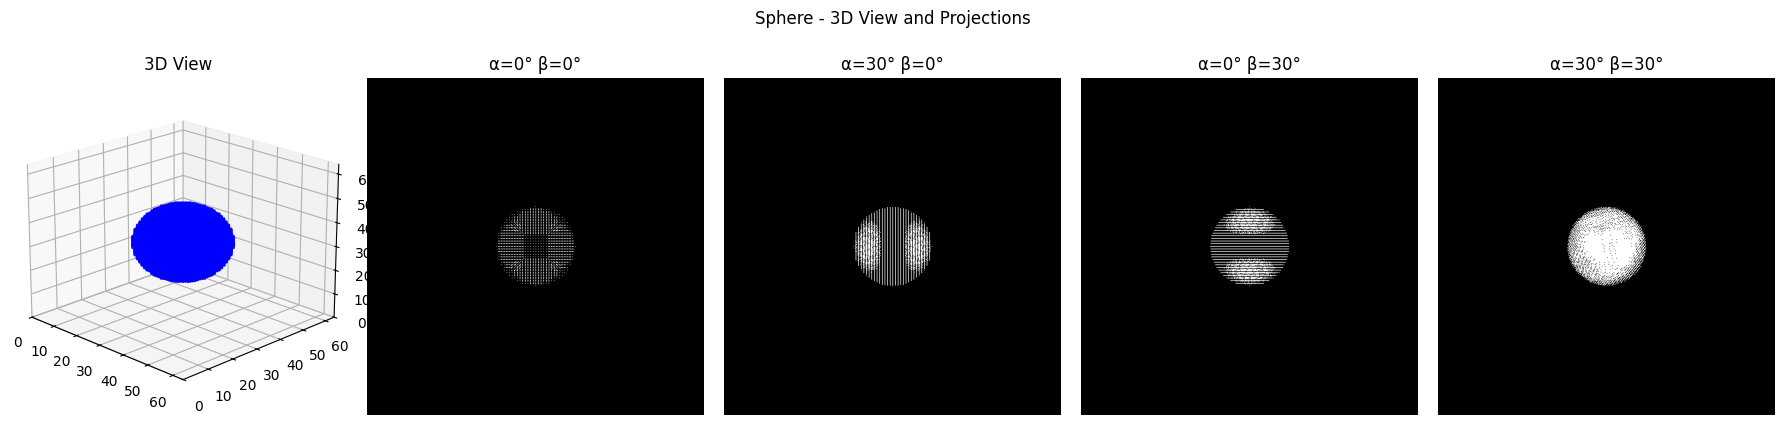


Visualizing Torus...


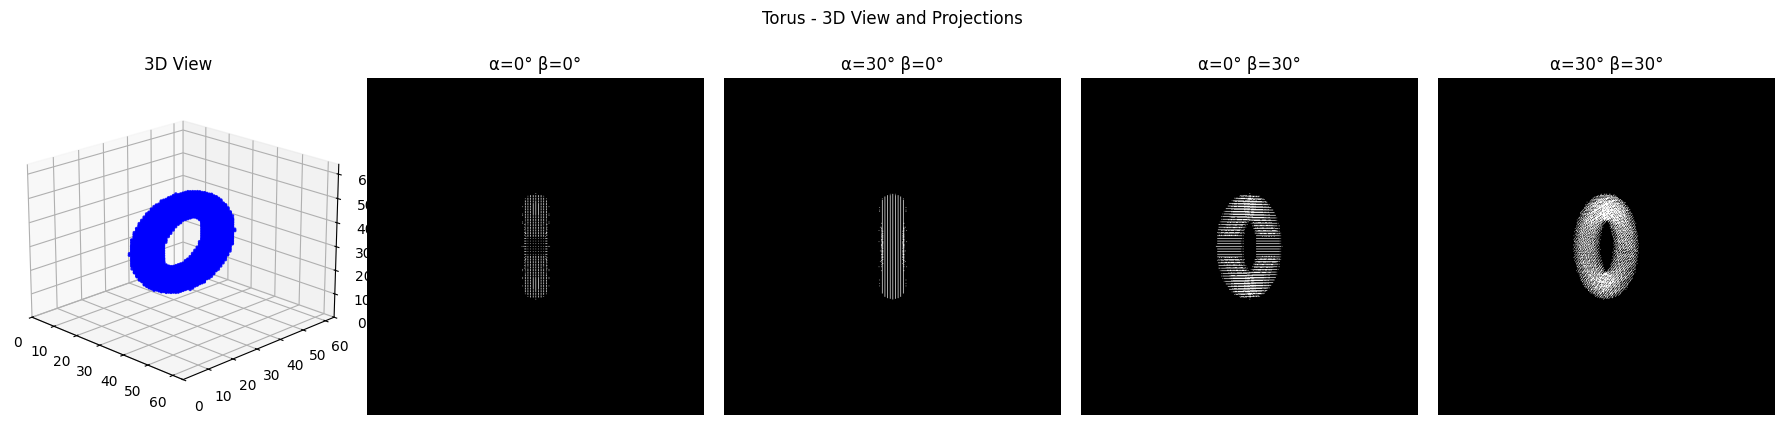


Visualizing Pyramid...


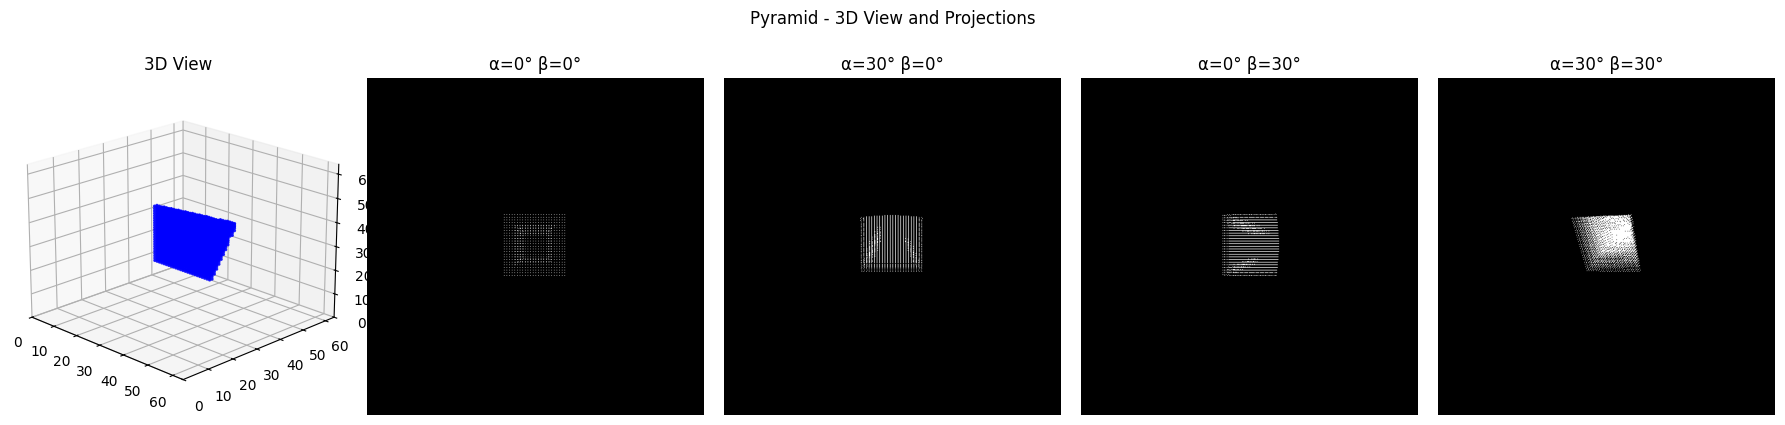


Visualizing Helix...


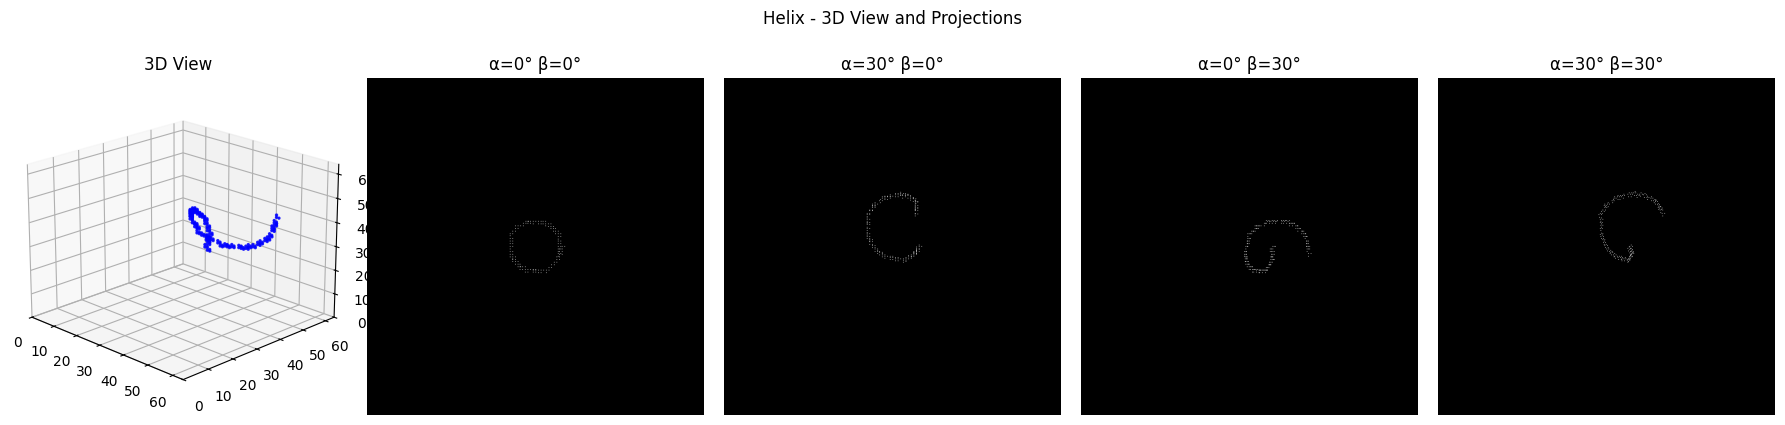


Reconstructing Cube...
全1输入时的最大投影值: 64.0


  0%|          | 8/5000 [00:00<02:19, 35.73it/s]

Iter <built-in function iter>: Loss=215098.05, Grad Norm=601.1362


  2%|▏         | 109/5000 [00:02<01:34, 51.62it/s]

Iter <built-in function iter>: Loss=118155.95, Grad Norm=426.6538


  4%|▍         | 205/5000 [00:04<01:32, 51.58it/s]

Iter <built-in function iter>: Loss=62239.92, Grad Norm=316.1905


  6%|▌         | 307/5000 [00:06<01:32, 50.67it/s]

Iter <built-in function iter>: Loss=26250.97, Grad Norm=254.7139


  8%|▊         | 409/5000 [00:08<01:29, 51.31it/s]

Iter <built-in function iter>: Loss=6604.18, Grad Norm=142.9237


 10%|█         | 511/5000 [00:09<01:28, 50.94it/s]

Iter <built-in function iter>: Loss=3022.93, Grad Norm=42.2371


 12%|█▏        | 607/5000 [00:11<01:25, 51.56it/s]

Iter <built-in function iter>: Loss=2710.35, Grad Norm=13.7551


 14%|█▍        | 709/5000 [00:13<01:23, 51.67it/s]

Iter <built-in function iter>: Loss=2671.72, Grad Norm=6.4090


 16%|█▌        | 811/5000 [00:15<01:21, 51.22it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0004


 18%|█▊        | 907/5000 [00:17<01:19, 51.40it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 20%|██        | 1009/5000 [00:19<01:17, 51.73it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 22%|██▏       | 1111/5000 [00:21<01:14, 51.92it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 24%|██▍       | 1207/5000 [00:23<01:14, 50.97it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 26%|██▌       | 1309/5000 [00:25<01:11, 51.80it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 28%|██▊       | 1411/5000 [00:27<01:09, 51.68it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 30%|███       | 1507/5000 [00:29<01:07, 51.85it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 32%|███▏      | 1609/5000 [00:31<01:05, 51.95it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 34%|███▍      | 1711/5000 [00:33<01:03, 51.56it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 36%|███▌      | 1807/5000 [00:35<01:02, 51.44it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 38%|███▊      | 1909/5000 [00:37<00:59, 51.89it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 40%|████      | 2011/5000 [00:39<00:58, 51.08it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 42%|████▏     | 2107/5000 [00:40<00:56, 51.49it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 44%|████▍     | 2209/5000 [00:42<00:54, 51.54it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 46%|████▌     | 2311/5000 [00:44<00:52, 51.48it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 48%|████▊     | 2407/5000 [00:46<00:50, 51.39it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 50%|█████     | 2509/5000 [00:48<00:48, 51.53it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 52%|█████▏    | 2611/5000 [00:50<00:46, 51.48it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 54%|█████▍    | 2707/5000 [00:52<00:44, 51.53it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 56%|█████▌    | 2809/5000 [00:54<00:42, 51.59it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 58%|█████▊    | 2910/5000 [00:56<00:41, 50.45it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 60%|██████    | 3006/5000 [00:58<00:39, 51.01it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 62%|██████▏   | 3108/5000 [01:00<00:36, 51.47it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 64%|██████▍   | 3210/5000 [01:02<00:35, 51.05it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 66%|██████▌   | 3306/5000 [01:04<00:32, 51.49it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 68%|██████▊   | 3408/5000 [01:06<00:31, 51.23it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 70%|███████   | 3510/5000 [01:08<00:28, 51.55it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 72%|███████▏  | 3606/5000 [01:10<00:27, 51.08it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 74%|███████▍  | 3708/5000 [01:12<00:25, 50.47it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 76%|███████▌  | 3810/5000 [01:14<00:23, 50.64it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 78%|███████▊  | 3906/5000 [01:16<00:21, 50.47it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 80%|████████  | 4008/5000 [01:18<00:19, 50.75it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 82%|████████▏ | 4110/5000 [01:20<00:17, 50.88it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 84%|████████▍ | 4206/5000 [01:21<00:15, 49.92it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 86%|████████▌ | 4306/5000 [01:24<00:14, 47.78it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 88%|████████▊ | 4410/5000 [01:26<00:11, 49.82it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 90%|█████████ | 4511/5000 [01:28<00:10, 47.97it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 92%|█████████▏| 4610/5000 [01:30<00:07, 49.22it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 94%|█████████▍| 4708/5000 [01:32<00:05, 49.77it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 96%|█████████▌| 4808/5000 [01:34<00:03, 49.25it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


 98%|█████████▊| 4911/5000 [01:36<00:01, 49.26it/s]

Iter <built-in function iter>: Loss=2667.00, Grad Norm=0.0000


100%|██████████| 5000/5000 [01:38<00:00, 50.98it/s]


tensor(2667., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Cylinder...
全1输入时的最大投影值: 64.0


  0%|          | 5/5000 [00:00<01:47, 46.35it/s]

Iter <built-in function iter>: Loss=211843.64, Grad Norm=596.7074


  2%|▏         | 106/5000 [00:02<01:38, 49.44it/s]

Iter <built-in function iter>: Loss=116008.36, Grad Norm=421.8140


  4%|▍         | 209/5000 [00:04<01:37, 49.35it/s]

Iter <built-in function iter>: Loss=62161.50, Grad Norm=310.0363


  6%|▌         | 309/5000 [00:06<01:38, 47.85it/s]

Iter <built-in function iter>: Loss=28214.74, Grad Norm=247.0627


  8%|▊         | 411/5000 [00:08<01:34, 48.55it/s]

Iter <built-in function iter>: Loss=8233.99, Grad Norm=149.5799


 10%|█         | 505/5000 [00:10<01:30, 49.61it/s]

Iter <built-in function iter>: Loss=4072.12, Grad Norm=46.2491


 12%|█▏        | 612/5000 [00:12<01:29, 49.13it/s]

Iter <built-in function iter>: Loss=3648.93, Grad Norm=17.5947


 14%|█▍        | 708/5000 [00:14<01:27, 49.13it/s]

Iter <built-in function iter>: Loss=3545.78, Grad Norm=8.7425


 16%|█▌        | 808/5000 [00:16<01:26, 48.28it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0004


 18%|█▊        | 908/5000 [00:18<01:23, 48.74it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 20%|██        | 1009/5000 [00:20<01:22, 48.52it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 22%|██▏       | 1109/5000 [00:22<01:20, 48.32it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 24%|██▍       | 1209/5000 [00:24<01:17, 48.80it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 26%|██▌       | 1309/5000 [00:26<01:14, 49.49it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 28%|██▊       | 1410/5000 [00:28<01:13, 49.17it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 30%|███       | 1508/5000 [00:30<01:10, 49.48it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 32%|███▏      | 1609/5000 [00:32<01:09, 48.84it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 34%|███▍      | 1711/5000 [00:35<01:06, 49.67it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 36%|███▌      | 1811/5000 [00:37<01:05, 48.61it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 38%|███▊      | 1911/5000 [00:39<01:02, 49.40it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 40%|████      | 2007/5000 [00:41<01:01, 48.35it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 42%|████▏     | 2108/5000 [00:43<01:00, 48.06it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 44%|████▍     | 2209/5000 [00:45<00:57, 48.24it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 46%|████▌     | 2309/5000 [00:47<00:54, 49.03it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 48%|████▊     | 2406/5000 [00:49<00:52, 49.24it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 50%|█████     | 2511/5000 [00:51<00:50, 49.15it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 52%|█████▏    | 2611/5000 [00:53<00:49, 48.20it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 54%|█████▍    | 2707/5000 [00:55<00:48, 47.70it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 56%|█████▌    | 2807/5000 [00:57<00:44, 48.80it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 58%|█████▊    | 2910/5000 [00:59<00:42, 49.50it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 60%|██████    | 3007/5000 [01:01<00:40, 49.50it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 62%|██████▏   | 3105/5000 [01:03<00:38, 49.08it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 64%|██████▍   | 3205/5000 [01:05<00:36, 49.11it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 66%|██████▌   | 3306/5000 [01:07<00:34, 49.37it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 68%|██████▊   | 3406/5000 [01:09<00:34, 46.74it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 70%|███████   | 3506/5000 [01:11<00:30, 48.23it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 72%|███████▏  | 3611/5000 [01:14<00:28, 48.45it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 74%|███████▍  | 3711/5000 [01:16<00:26, 47.76it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 76%|███████▌  | 3806/5000 [01:18<00:24, 47.77it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 78%|███████▊  | 3906/5000 [01:20<00:22, 48.26it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 80%|████████  | 4007/5000 [01:22<00:20, 49.27it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 82%|████████▏ | 4107/5000 [01:24<00:18, 48.42it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 84%|████████▍ | 4207/5000 [01:26<00:16, 47.69it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 86%|████████▌ | 4307/5000 [01:28<00:14, 48.16it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 88%|████████▊ | 4407/5000 [01:30<00:12, 47.66it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 90%|█████████ | 4507/5000 [01:32<00:10, 48.11it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 92%|█████████▏| 4607/5000 [01:34<00:08, 48.21it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 94%|█████████▍| 4707/5000 [01:36<00:06, 48.15it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 96%|█████████▌| 4807/5000 [01:38<00:04, 47.69it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


 98%|█████████▊| 4907/5000 [01:41<00:01, 47.02it/s]

Iter <built-in function iter>: Loss=3531.00, Grad Norm=0.0000


100%|██████████| 5000/5000 [01:42<00:00, 48.55it/s]


tensor(3531., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Star...
全1输入时的最大投影值: 64.0


  0%|          | 5/5000 [00:00<01:46, 46.70it/s]

Iter <built-in function iter>: Loss=224294.48, Grad Norm=606.0406


  2%|▏         | 110/5000 [00:02<01:41, 48.13it/s]

Iter <built-in function iter>: Loss=125860.15, Grad Norm=429.1606


  4%|▍         | 210/5000 [00:04<01:41, 47.10it/s]

Iter <built-in function iter>: Loss=68429.02, Grad Norm=326.5725


  6%|▌         | 310/5000 [00:06<01:37, 47.92it/s]

Iter <built-in function iter>: Loss=27927.95, Grad Norm=288.1031


  8%|▊         | 410/5000 [00:08<01:34, 48.52it/s]

Iter <built-in function iter>: Loss=4816.65, Grad Norm=130.1357


 10%|█         | 510/5000 [00:10<01:32, 48.61it/s]

Iter <built-in function iter>: Loss=1639.81, Grad Norm=57.1114


 12%|█▏        | 610/5000 [00:12<01:32, 47.69it/s]

Iter <built-in function iter>: Loss=604.35, Grad Norm=31.4740


 14%|█▍        | 710/5000 [00:14<01:31, 46.93it/s]

Iter <built-in function iter>: Loss=368.97, Grad Norm=14.0446


 16%|█▌        | 805/5000 [00:16<01:27, 47.97it/s]

Iter <built-in function iter>: Loss=324.60, Grad Norm=7.8395


 18%|█▊        | 910/5000 [00:19<01:25, 47.94it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 20%|██        | 1005/5000 [00:20<01:23, 47.88it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 22%|██▏       | 1110/5000 [00:23<01:21, 47.86it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 24%|██▍       | 1205/5000 [00:25<01:19, 47.64it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 26%|██▌       | 1310/5000 [00:27<01:16, 48.11it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 28%|██▊       | 1410/5000 [00:29<01:14, 48.22it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 30%|███       | 1510/5000 [00:31<01:12, 47.81it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 32%|███▏      | 1605/5000 [00:33<01:11, 47.79it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 34%|███▍      | 1705/5000 [00:35<01:08, 48.36it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 36%|███▌      | 1810/5000 [00:37<01:05, 48.50it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 38%|███▊      | 1905/5000 [00:39<01:03, 48.57it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 40%|████      | 2010/5000 [00:41<01:01, 48.62it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 42%|████▏     | 2105/5000 [00:43<01:00, 47.92it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 44%|████▍     | 2210/5000 [00:46<00:59, 46.60it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 46%|████▌     | 2305/5000 [00:48<00:56, 47.35it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 48%|████▊     | 2410/5000 [00:50<00:54, 47.96it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 50%|█████     | 2510/5000 [00:52<00:51, 47.91it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 52%|█████▏    | 2610/5000 [00:54<00:49, 48.01it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 54%|█████▍    | 2710/5000 [00:56<00:47, 48.09it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 56%|█████▌    | 2810/5000 [00:58<00:45, 47.73it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 58%|█████▊    | 2910/5000 [01:00<00:43, 47.58it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 60%|██████    | 3005/5000 [01:02<00:43, 46.21it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 62%|██████▏   | 3105/5000 [01:04<00:40, 47.35it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 64%|██████▍   | 3210/5000 [01:07<00:37, 48.19it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 66%|██████▌   | 3305/5000 [01:09<00:35, 48.12it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 68%|██████▊   | 3405/5000 [01:11<00:33, 47.52it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 70%|███████   | 3510/5000 [01:13<00:31, 47.56it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 72%|███████▏  | 3610/5000 [01:15<00:28, 48.43it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 74%|███████▍  | 3710/5000 [01:17<00:26, 47.92it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 76%|███████▌  | 3810/5000 [01:19<00:24, 47.94it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 78%|███████▊  | 3910/5000 [01:21<00:22, 48.41it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 80%|████████  | 4010/5000 [01:23<00:20, 48.53it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 82%|████████▏ | 4110/5000 [01:25<00:18, 48.26it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 84%|████████▍ | 4205/5000 [01:27<00:16, 48.40it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 86%|████████▌ | 4310/5000 [01:30<00:14, 47.78it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 88%|████████▊ | 4410/5000 [01:32<00:12, 47.94it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 90%|█████████ | 4510/5000 [01:34<00:10, 46.80it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 92%|█████████▏| 4610/5000 [01:36<00:08, 47.89it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 94%|█████████▍| 4710/5000 [01:38<00:06, 48.26it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 96%|█████████▌| 4810/5000 [01:40<00:03, 48.54it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


 98%|█████████▊| 4910/5000 [01:42<00:01, 48.25it/s]

Iter <built-in function iter>: Loss=311.00, Grad Norm=0.0000


100%|██████████| 5000/5000 [01:44<00:00, 47.86it/s]


tensor(311., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Sphere...
全1输入时的最大投影值: 64.0


  0%|          | 5/5000 [00:00<01:45, 47.41it/s]

Iter <built-in function iter>: Loss=207804.03, Grad Norm=599.7247


  2%|▏         | 110/5000 [00:02<01:42, 47.74it/s]

Iter <built-in function iter>: Loss=111110.02, Grad Norm=426.1280


  4%|▍         | 205/5000 [00:04<01:40, 47.55it/s]

Iter <built-in function iter>: Loss=57642.38, Grad Norm=298.2249


  6%|▌         | 305/5000 [00:06<01:39, 47.19it/s]

Iter <built-in function iter>: Loss=24830.62, Grad Norm=240.1966


  8%|▊         | 405/5000 [00:08<01:36, 47.73it/s]

Iter <built-in function iter>: Loss=7356.26, Grad Norm=121.5155


 10%|█         | 505/5000 [00:10<01:34, 47.46it/s]

Iter <built-in function iter>: Loss=4042.95, Grad Norm=42.9340


 12%|█▏        | 610/5000 [00:12<01:32, 47.52it/s]

Iter <built-in function iter>: Loss=3614.35, Grad Norm=11.9563


 14%|█▍        | 710/5000 [00:14<01:28, 48.26it/s]

Iter <built-in function iter>: Loss=3584.83, Grad Norm=5.2778


 16%|█▌        | 810/5000 [00:16<01:27, 47.82it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0004


 18%|█▊        | 910/5000 [00:19<01:24, 48.30it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 20%|██        | 1010/5000 [00:21<01:24, 47.02it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 22%|██▏       | 1110/5000 [00:23<01:21, 47.89it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 24%|██▍       | 1210/5000 [00:25<01:17, 48.60it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 26%|██▌       | 1310/5000 [00:27<01:15, 48.63it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 28%|██▊       | 1410/5000 [00:29<01:13, 48.74it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 30%|███       | 1510/5000 [00:31<01:11, 48.88it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 32%|███▏      | 1610/5000 [00:33<01:09, 48.62it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 34%|███▍      | 1710/5000 [00:35<01:07, 48.78it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 36%|███▌      | 1805/5000 [00:37<01:07, 47.38it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 38%|███▊      | 1910/5000 [00:39<01:03, 48.49it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 40%|████      | 2005/5000 [00:41<01:01, 48.66it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 42%|████▏     | 2105/5000 [00:43<00:59, 48.48it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 44%|████▍     | 2205/5000 [00:45<00:57, 48.69it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 46%|████▌     | 2310/5000 [00:48<00:55, 48.34it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 48%|████▊     | 2405/5000 [00:50<00:53, 48.65it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 50%|█████     | 2510/5000 [00:52<00:51, 48.53it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 52%|█████▏    | 2610/5000 [00:54<00:51, 46.52it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 54%|█████▍    | 2710/5000 [00:56<00:47, 48.26it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 56%|█████▌    | 2810/5000 [00:58<00:45, 48.50it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 58%|█████▊    | 2905/5000 [01:00<00:43, 48.28it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 60%|██████    | 3010/5000 [01:02<00:41, 48.16it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 62%|██████▏   | 3110/5000 [01:04<00:39, 47.85it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 64%|██████▍   | 3210/5000 [01:06<00:37, 48.35it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 66%|██████▌   | 3305/5000 [01:08<00:35, 48.02it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 68%|██████▊   | 3410/5000 [01:10<00:33, 47.52it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 70%|███████   | 3510/5000 [01:13<00:30, 48.22it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 72%|███████▏  | 3605/5000 [01:14<00:28, 48.29it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 74%|███████▍  | 3710/5000 [01:17<00:26, 48.16it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 76%|███████▌  | 3805/5000 [01:19<00:24, 48.27it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 78%|███████▊  | 3905/5000 [01:21<00:22, 48.15it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 80%|████████  | 4010/5000 [01:23<00:20, 48.08it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 82%|████████▏ | 4105/5000 [01:25<00:18, 47.30it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 84%|████████▍ | 4205/5000 [01:27<00:16, 47.87it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 86%|████████▌ | 4310/5000 [01:29<00:14, 48.19it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 88%|████████▊ | 4410/5000 [01:31<00:12, 47.97it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 90%|█████████ | 4505/5000 [01:33<00:10, 47.95it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 92%|█████████▏| 4610/5000 [01:35<00:08, 48.40it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 94%|█████████▍| 4705/5000 [01:37<00:06, 48.31it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 96%|█████████▌| 4810/5000 [01:40<00:03, 48.34it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


 98%|█████████▊| 4905/5000 [01:42<00:02, 47.03it/s]

Iter <built-in function iter>: Loss=3584.00, Grad Norm=0.0000


100%|██████████| 5000/5000 [01:44<00:00, 48.07it/s]


tensor(3584., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Torus...
全1输入时的最大投影值: 64.0


  0%|          | 5/5000 [00:00<01:45, 47.14it/s]

Iter <built-in function iter>: Loss=214018.48, Grad Norm=600.7924


  2%|▏         | 110/5000 [00:02<01:41, 48.09it/s]

Iter <built-in function iter>: Loss=117365.96, Grad Norm=417.0675


  4%|▍         | 205/5000 [00:04<01:39, 47.96it/s]

Iter <built-in function iter>: Loss=62881.44, Grad Norm=309.7043


  6%|▌         | 310/5000 [00:06<01:37, 48.27it/s]

Iter <built-in function iter>: Loss=27635.51, Grad Norm=249.7724


  8%|▊         | 410/5000 [00:08<01:35, 47.96it/s]

Iter <built-in function iter>: Loss=9226.13, Grad Norm=128.6205


 10%|█         | 505/5000 [00:10<01:33, 48.32it/s]

Iter <built-in function iter>: Loss=5644.55, Grad Norm=50.3697


 12%|█▏        | 605/5000 [00:12<01:31, 47.82it/s]

Iter <built-in function iter>: Loss=5069.34, Grad Norm=14.8575


 14%|█▍        | 705/5000 [00:14<01:32, 46.60it/s]

Iter <built-in function iter>: Loss=4995.68, Grad Norm=7.3802


 16%|█▌        | 810/5000 [00:16<01:27, 48.03it/s]

Iter <built-in function iter>: Loss=4980.26, Grad Norm=5.6329


 18%|█▊        | 910/5000 [00:18<01:25, 48.09it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 20%|██        | 1005/5000 [00:20<01:23, 47.94it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 22%|██▏       | 1105/5000 [00:23<01:21, 47.84it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 24%|██▍       | 1210/5000 [00:25<01:18, 48.10it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 26%|██▌       | 1305/5000 [00:27<01:18, 47.27it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 28%|██▊       | 1405/5000 [00:29<01:23, 43.01it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 30%|███       | 1510/5000 [00:31<01:13, 47.51it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 32%|███▏      | 1610/5000 [00:33<01:12, 46.75it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 34%|███▍      | 1710/5000 [00:35<01:07, 48.42it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 36%|███▌      | 1810/5000 [00:37<01:07, 47.20it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 38%|███▊      | 1905/5000 [00:39<01:05, 47.51it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 40%|████      | 2010/5000 [00:42<01:01, 48.35it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 42%|████▏     | 2110/5000 [00:44<00:59, 48.24it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 44%|████▍     | 2210/5000 [00:46<01:00, 46.08it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 46%|████▌     | 2310/5000 [00:48<00:57, 46.85it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 48%|████▊     | 2405/5000 [00:50<00:55, 47.17it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 50%|█████     | 2505/5000 [00:52<00:52, 47.86it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 52%|█████▏    | 2610/5000 [00:54<00:49, 47.99it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 54%|█████▍    | 2705/5000 [00:56<00:48, 47.69it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 56%|█████▌    | 2810/5000 [00:58<00:45, 48.32it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 58%|█████▊    | 2905/5000 [01:00<00:43, 47.76it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 60%|██████    | 3010/5000 [01:03<00:41, 48.20it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 62%|██████▏   | 3110/5000 [01:05<00:38, 48.62it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 64%|██████▍   | 3210/5000 [01:07<00:37, 48.31it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 66%|██████▌   | 3310/5000 [01:09<00:34, 48.35it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 68%|██████▊   | 3405/5000 [01:11<00:34, 46.23it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 70%|███████   | 3510/5000 [01:13<00:31, 47.82it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 72%|███████▏  | 3610/5000 [01:15<00:28, 48.51it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 74%|███████▍  | 3710/5000 [01:17<00:27, 46.21it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 76%|███████▌  | 3810/5000 [01:19<00:24, 48.20it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 78%|███████▊  | 3910/5000 [01:22<00:22, 48.20it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 80%|████████  | 4010/5000 [01:24<00:20, 48.24it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 82%|████████▏ | 4110/5000 [01:26<00:18, 48.01it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 84%|████████▍ | 4210/5000 [01:28<00:16, 48.04it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 86%|████████▌ | 4310/5000 [01:30<00:14, 48.29it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 88%|████████▊ | 4410/5000 [01:32<00:12, 48.14it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 90%|█████████ | 4505/5000 [01:34<00:10, 47.19it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 92%|█████████▏| 4605/5000 [01:36<00:08, 48.08it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 94%|█████████▍| 4705/5000 [01:38<00:06, 48.46it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 96%|█████████▌| 4810/5000 [01:40<00:04, 47.33it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


 98%|█████████▊| 4910/5000 [01:42<00:01, 47.47it/s]

Iter <built-in function iter>: Loss=4976.00, Grad Norm=0.0000


100%|██████████| 5000/5000 [01:44<00:00, 47.72it/s]


tensor(4976., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Pyramid...
全1输入时的最大投影值: 64.0


  0%|          | 5/5000 [00:00<01:46, 46.94it/s]

Iter <built-in function iter>: Loss=218181.09, Grad Norm=603.8495


  2%|▏         | 110/5000 [00:02<01:41, 47.95it/s]

Iter <built-in function iter>: Loss=120556.05, Grad Norm=422.2171


  4%|▍         | 205/5000 [00:04<01:41, 47.17it/s]

Iter <built-in function iter>: Loss=64424.70, Grad Norm=318.2810


  6%|▌         | 310/5000 [00:06<01:38, 47.68it/s]

Iter <built-in function iter>: Loss=25629.52, Grad Norm=268.4499


  8%|▊         | 405/5000 [00:08<01:39, 46.00it/s]

Iter <built-in function iter>: Loss=5057.67, Grad Norm=127.8766


 10%|█         | 510/5000 [00:10<01:37, 46.22it/s]

Iter <built-in function iter>: Loss=2818.24, Grad Norm=31.2252


 12%|█▏        | 610/5000 [00:12<01:33, 46.77it/s]

Iter <built-in function iter>: Loss=2547.54, Grad Norm=7.5686


 14%|█▍        | 705/5000 [00:14<01:32, 46.59it/s]

Iter <built-in function iter>: Loss=2471.80, Grad Norm=8.7361


 16%|█▌        | 810/5000 [00:17<01:27, 48.03it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 18%|█▊        | 905/5000 [00:19<01:25, 47.62it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 20%|██        | 1005/5000 [00:21<01:25, 46.93it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 22%|██▏       | 1110/5000 [00:23<01:21, 47.86it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 24%|██▍       | 1210/5000 [00:25<01:19, 47.73it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 26%|██▌       | 1305/5000 [00:27<01:17, 47.59it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 28%|██▊       | 1405/5000 [00:29<01:14, 48.07it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 30%|███       | 1510/5000 [00:31<01:12, 47.87it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 32%|███▏      | 1610/5000 [00:34<01:10, 47.95it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 34%|███▍      | 1710/5000 [00:36<01:09, 47.50it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 36%|███▌      | 1810/5000 [00:38<01:06, 47.65it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 38%|███▊      | 1910/5000 [00:40<01:04, 48.18it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 40%|████      | 2010/5000 [00:42<01:02, 48.11it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 42%|████▏     | 2110/5000 [00:44<01:00, 47.83it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 44%|████▍     | 2210/5000 [00:46<00:58, 47.75it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 46%|████▌     | 2305/5000 [00:48<00:56, 47.93it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 48%|████▊     | 2410/5000 [00:50<00:53, 48.06it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 50%|█████     | 2505/5000 [00:52<00:53, 46.81it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 52%|█████▏    | 2610/5000 [00:54<00:50, 46.99it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 54%|█████▍    | 2705/5000 [00:56<00:48, 47.44it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 56%|█████▌    | 2810/5000 [00:59<00:45, 47.70it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 58%|█████▊    | 2905/5000 [01:01<00:44, 47.51it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 60%|██████    | 3010/5000 [01:03<00:42, 47.16it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 62%|██████▏   | 3105/5000 [01:05<00:39, 48.06it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 64%|██████▍   | 3205/5000 [01:07<00:37, 47.79it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 66%|██████▌   | 3310/5000 [01:09<00:35, 47.23it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 68%|██████▊   | 3405/5000 [01:11<00:33, 47.94it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 70%|███████   | 3510/5000 [01:13<00:30, 48.16it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 72%|███████▏  | 3605/5000 [01:15<00:29, 47.58it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 74%|███████▍  | 3710/5000 [01:17<00:27, 47.76it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 76%|███████▌  | 3810/5000 [01:20<00:24, 47.90it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 78%|███████▊  | 3905/5000 [01:22<00:22, 48.04it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 80%|████████  | 4010/5000 [01:24<00:21, 46.85it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 82%|████████▏ | 4105/5000 [01:26<00:19, 46.87it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 84%|████████▍ | 4205/5000 [01:28<00:16, 47.76it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 86%|████████▌ | 4305/5000 [01:30<00:14, 46.45it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 88%|████████▊ | 4405/5000 [01:32<00:12, 47.78it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 90%|█████████ | 4510/5000 [01:34<00:10, 47.69it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 92%|█████████▏| 4605/5000 [01:36<00:08, 47.29it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 94%|█████████▍| 4710/5000 [01:39<00:06, 47.16it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 96%|█████████▌| 4810/5000 [01:41<00:04, 46.48it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


 98%|█████████▊| 4910/5000 [01:43<00:01, 47.40it/s]

Iter <built-in function iter>: Loss=2461.00, Grad Norm=0.0000


100%|██████████| 5000/5000 [01:45<00:00, 47.53it/s]


tensor(2461., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Helix...
全1输入时的最大投影值: 64.0


  0%|          | 5/5000 [00:00<01:46, 46.92it/s]

Iter <built-in function iter>: Loss=226252.75, Grad Norm=605.1985


  2%|▏         | 110/5000 [00:02<01:44, 46.99it/s]

Iter <built-in function iter>: Loss=128266.80, Grad Norm=422.8214


  4%|▍         | 205/5000 [00:04<01:42, 46.85it/s]

Iter <built-in function iter>: Loss=70796.23, Grad Norm=323.2525


  6%|▌         | 305/5000 [00:06<01:39, 47.16it/s]

Iter <built-in function iter>: Loss=29254.11, Grad Norm=287.4090


  8%|▊         | 405/5000 [00:08<01:39, 46.27it/s]

Iter <built-in function iter>: Loss=5626.97, Grad Norm=148.3248


 10%|█         | 505/5000 [00:10<01:36, 46.70it/s]

Iter <built-in function iter>: Loss=232.06, Grad Norm=87.0660


 12%|█▏        | 605/5000 [00:12<01:39, 44.31it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 14%|█▍        | 710/5000 [00:15<01:30, 47.20it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 16%|█▌        | 810/5000 [00:17<01:28, 47.31it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 18%|█▊        | 905/5000 [00:19<01:26, 47.57it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 20%|██        | 1010/5000 [00:21<01:24, 47.04it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 22%|██▏       | 1105/5000 [00:23<01:22, 47.27it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 24%|██▍       | 1205/5000 [00:25<01:21, 46.54it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 26%|██▌       | 1310/5000 [00:27<01:20, 45.80it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 28%|██▊       | 1405/5000 [00:29<01:15, 47.37it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 30%|███       | 1505/5000 [00:32<01:13, 47.44it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 32%|███▏      | 1610/5000 [00:34<01:12, 46.66it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 34%|███▍      | 1705/5000 [00:36<01:09, 47.40it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 36%|███▌      | 1810/5000 [00:38<01:07, 46.97it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 38%|███▊      | 1905/5000 [00:40<01:04, 47.67it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 40%|████      | 2005/5000 [00:42<01:03, 46.92it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 42%|████▏     | 2105/5000 [00:44<01:02, 45.97it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 44%|████▍     | 2205/5000 [00:47<00:59, 46.66it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 46%|████▌     | 2305/5000 [00:49<00:58, 46.26it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 48%|████▊     | 2405/5000 [00:51<00:54, 47.79it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 50%|█████     | 2505/5000 [00:53<00:53, 46.50it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 52%|█████▏    | 2605/5000 [00:55<00:51, 46.69it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 54%|█████▍    | 2705/5000 [00:57<00:48, 46.89it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 56%|█████▌    | 2810/5000 [00:59<00:47, 46.01it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 58%|█████▊    | 2905/5000 [01:02<00:46, 45.50it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 60%|██████    | 3005/5000 [01:04<00:42, 47.03it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 62%|██████▏   | 3110/5000 [01:06<00:40, 46.72it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 64%|██████▍   | 3205/5000 [01:08<00:37, 47.25it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 66%|██████▌   | 3305/5000 [01:10<00:36, 46.51it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 68%|██████▊   | 3410/5000 [01:12<00:33, 47.69it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 70%|███████   | 3505/5000 [01:14<00:32, 46.71it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 72%|███████▏  | 3610/5000 [01:17<00:31, 44.71it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 74%|███████▍  | 3705/5000 [01:19<00:29, 44.20it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 76%|███████▌  | 3810/5000 [01:21<00:25, 47.40it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 78%|███████▊  | 3910/5000 [01:23<00:23, 46.42it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 80%|████████  | 4010/5000 [01:25<00:20, 47.35it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 82%|████████▏ | 4110/5000 [01:27<00:18, 47.52it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 84%|████████▍ | 4205/5000 [01:29<00:16, 47.36it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 86%|████████▌ | 4305/5000 [01:31<00:14, 46.45it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 88%|████████▊ | 4405/5000 [01:34<00:12, 47.50it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 90%|█████████ | 4510/5000 [01:36<00:10, 47.53it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 92%|█████████▏| 4605/5000 [01:38<00:08, 47.03it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 94%|█████████▍| 4705/5000 [01:40<00:06, 47.49it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 96%|█████████▌| 4805/5000 [01:42<00:04, 47.10it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 98%|█████████▊| 4905/5000 [01:44<00:02, 47.50it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


100%|██████████| 5000/5000 [01:46<00:00, 46.88it/s]


tensor(0., device='cuda:0', grad_fn=<AddBackward0>)


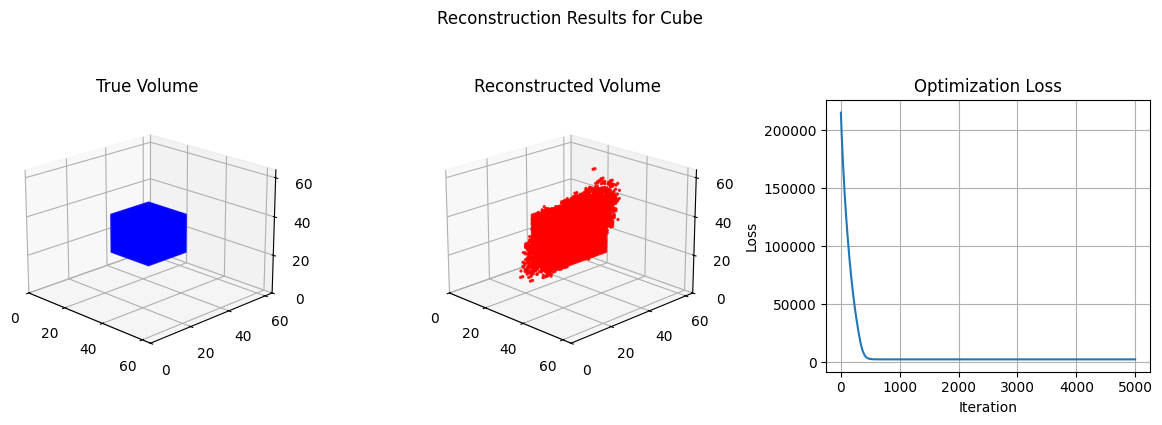

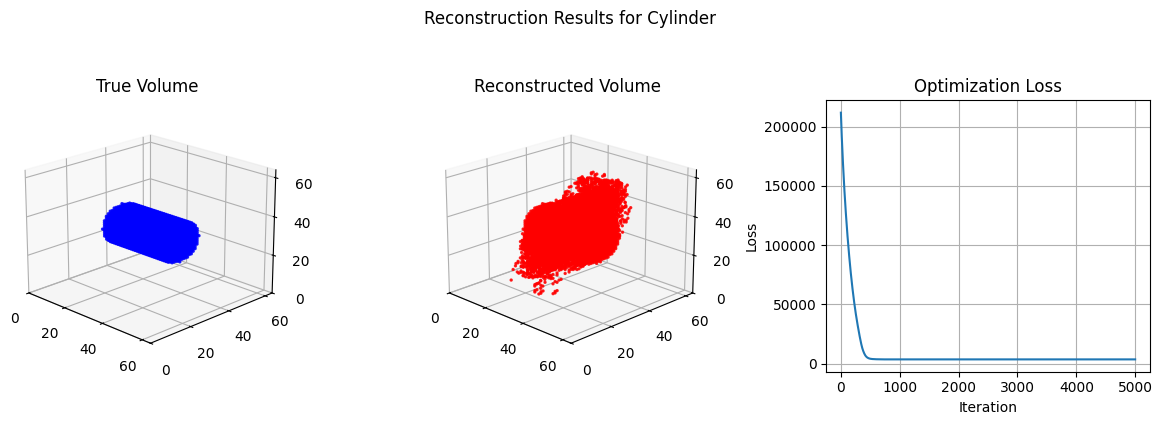

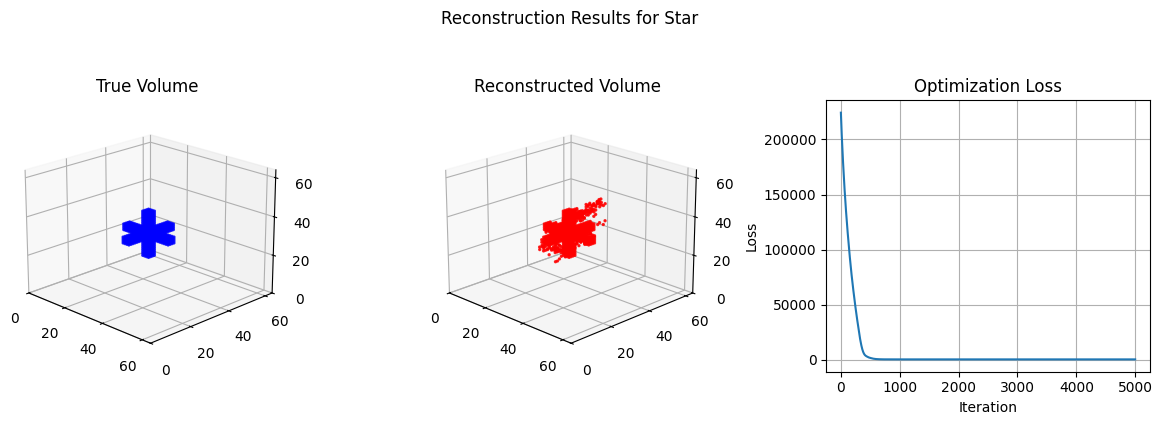

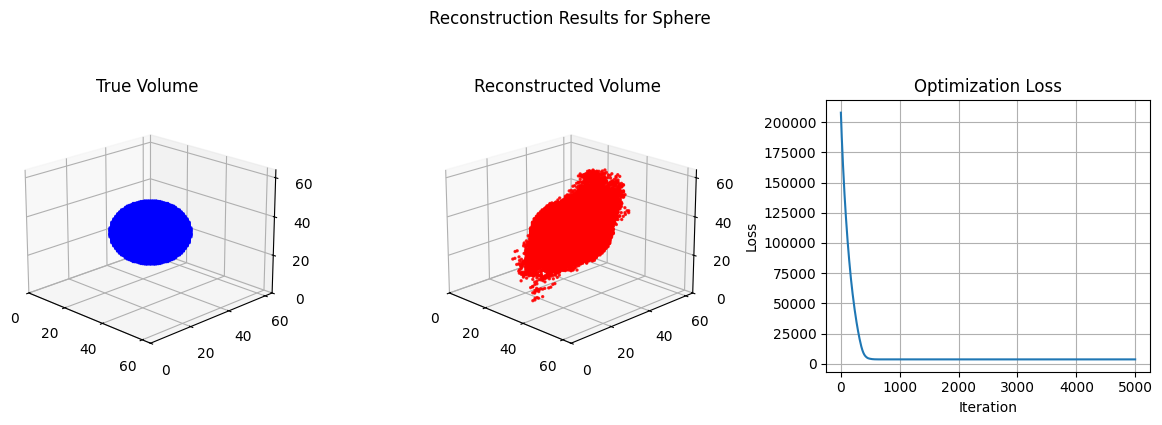

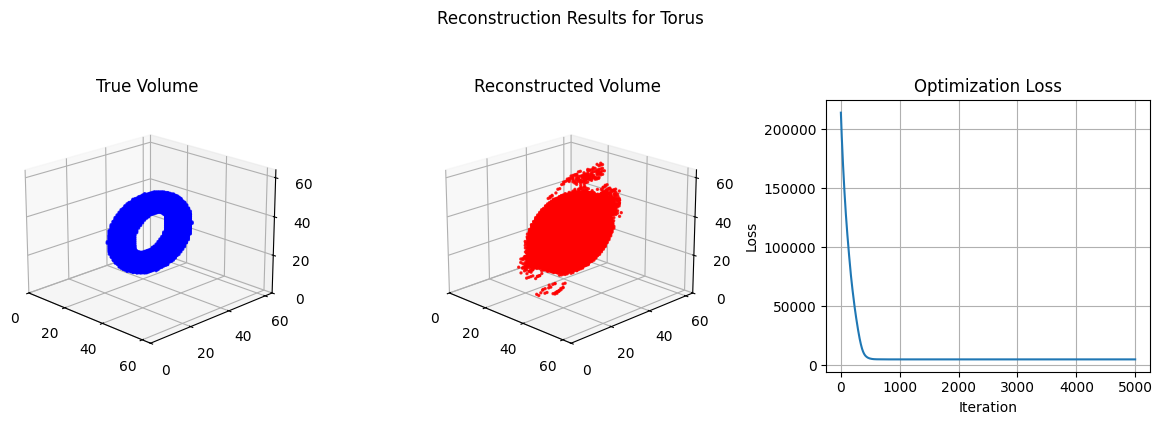

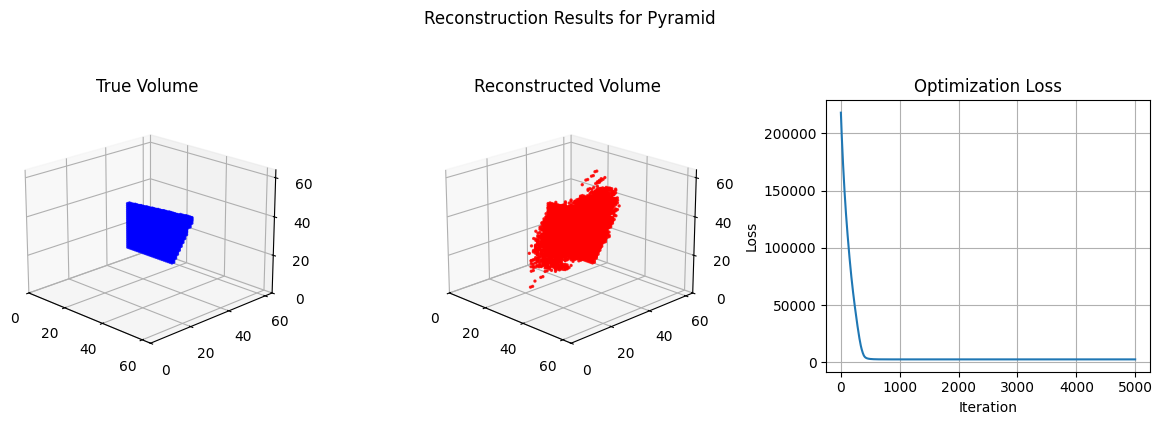

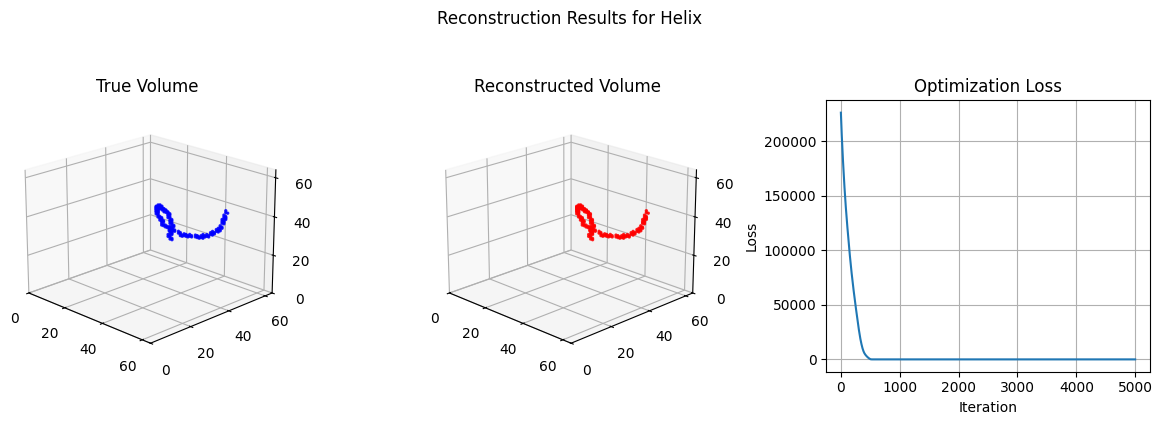

In [17]:
def reconstruct_from_projections(test_objects, projector, num_iterations=5000, lr=0.01):
    """Reconstruct 3D objects from their projections using optimization"""
    results = {}
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nReconstructing {obj_name}...")
        
        # 1. Get the ground truth projections (I_k)
        projections = []
        projection_matrices = []
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            projections.append(I_k)
            #print(I_k.float().max(),I_k.float().min())
            projection_matrices.append(P)

        #P = projection_matrices[0]
        #test_input = torch.ones(volume_shape).flatten().to(device)
        #output = torch.sparse.mm(P, test_input.unsqueeze(-1)).max()
        #print(f"全1输入时的最大投影值: {output.item()}")  # 如果>>1，说明需要归一化

        #P = projection_matrices[0]
        #print(f"Projection matrix max value: {P._values().max().item()}")
        #if P._values().max() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().max())
        #print(f"Projection matrix min value: {P._values().min().item()}")
        #if P._values().min() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().min())
        
        # 2. Initialize the reconstructed volume (relaxed to [0,1])
        X_recon = torch.rand(projector.volume_shape, device=device, requires_grad=True)
        
        # 3. Set up optimizer
        optimizer = torch.optim.Adam([X_recon], lr=lr)
        
        # 4. Optimization loop
        loss_history = []
        best_loss = float('inf')
        best_X = None
        
        for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            
            # Compute all projections
            total_loss = 0
            vec_X = X_recon.flatten()
            
            for P, I_k in zip(projection_matrices, projections):
                # Compute P·vec(X)
                proj = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
                #proj = proj.reshape(I_k.shape)# no max operator
                proj = proj.clamp(max=1.0).reshape(I_k.shape)
                
                # Compute Frobenius norm squared
                loss = torch.norm(proj - I_k.float(), p='fro')**2
                total_loss += loss
            
            # Add regularization to encourage binary solutions
            # This helps push values toward 0 or 1
            #reg = torch.norm(X_recon * (1 - X_recon), p=1)  # Encourages values to be 0 or 1
            #total_loss += 0.1 * reg
            
            # Track best solution
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_X = X_recon.detach().clone()
            
            loss_history.append(total_loss.item())
            
            # Backpropagate and update
            total_loss.backward()
            if iteration % 100 == 0:
                grad_norm = X_recon.grad.norm().item()
                print(f"Iter {iter}: Loss={total_loss.item():.2f}, Grad Norm={grad_norm:.4f}")
            optimizer.step()
            
            # Project back to [0,1] range
            with torch.no_grad():
                X_recon.data = torch.clamp(X_recon, 0, 1)

        print(total_loss)
        
        # 5. Store results (use the best solution found during optimization)
        threshold = 0.5  # For converting back to binary
        binary_recon = (best_X > threshold).float()
        results[obj_name] = {
            'true': true_volume,
            'reconstructed': binary_recon,
            'relaxed': best_X,
            'loss_history': loss_history
        }
    
    return results

def visualize_reconstruction_results(results):
    """Visualize true and reconstructed volumes"""
    for obj_name, data in results.items():
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f'Reconstruction Results for {obj_name}', y=1.05)
        
        # True volume
        ax1 = fig.add_subplot(131, projection='3d')
        coords = torch.nonzero(data['true']).cpu().numpy()
        if len(coords) > 0:
            ax1.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                      color='blue', s=2, alpha=0.8)
        ax1.set_title('True Volume')
        ax1.set_xlim(0, data['true'].shape[2])
        ax1.set_ylim(0, data['true'].shape[0])
        ax1.set_zlim(0, data['true'].shape[1])
        ax1.view_init(elev=20, azim=-45)
        
        # Reconstructed volume (binary)
        ax2 = fig.add_subplot(132, projection='3d')
        coords = torch.nonzero(data['reconstructed']).cpu().numpy()
        if len(coords) > 0:
            ax2.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                       color='red', s=2, alpha=0.8)
        ax2.set_title('Reconstructed Volume')
        ax2.set_xlim(0, data['reconstructed'].shape[2])
        ax2.set_ylim(0, data['reconstructed'].shape[0])
        ax2.set_zlim(0, data['reconstructed'].shape[1])
        ax2.view_init(elev=20, azim=-45)
        
        # Loss curve
        ax3 = fig.add_subplot(133)
        ax3.plot(data['loss_history'])
        ax3.set_title('Optimization Loss')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Loss')
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    volume_shape = (64, 64, 64)
    projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
    test_objects = create_test_objects(volume_shape)
    
    # First visualize the objects and their projections
    visualize_all_objects(test_objects, projector)
    
    # Then perform reconstruction
    reconstruction_results = reconstruct_from_projections(test_objects, projector)
    
    # Visualize reconstruction results
    visualize_reconstruction_results(reconstruction_results)